### MNIST using MLP and Transfer Learning

The task of this assignment is to train a MLP model on MNIST classification. The second task is to use transfer learning (or re-training) to train another model for a letter classification task.

**important**: before turning in your final notebook for grading, make sure to make a "clean" run. Choose "Restart & Run All" from the "Kernel" pulldown menu. The indices of runs must be sequential and start with 1

**important**: rename the notebook with your UID as the prefix, such as jdoe001_xxxxxxx.ipynb, and put your name below

**Name**: Ashish Verma

In [1]:
#Importing necessary packages.
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.utils as utils
from torch.utils.data import DataLoader,random_split
from torchvision import datasets
from torchvision.datasets import EMNIST, KMNIST

import numpy as np

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
## Load MNIST digit datasets
train_data = torchvision.datasets.MNIST('./data',download=True)
test_data = torchvision.datasets.MNIST('./data', train=False)
num_classes = len(train_data.classes)
print(train_data)
print(test_data)
print("Number of classes = {0:d}".format(num_classes))

100%|██████████| 9912422/9912422 [00:00<00:00, 110562232.23it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 53957992.79it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35024797.28it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21073593.77it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Number of classes = 10


In [4]:
# Apply transforms to the loaded dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data.transform = transform
test_data.transform = transform

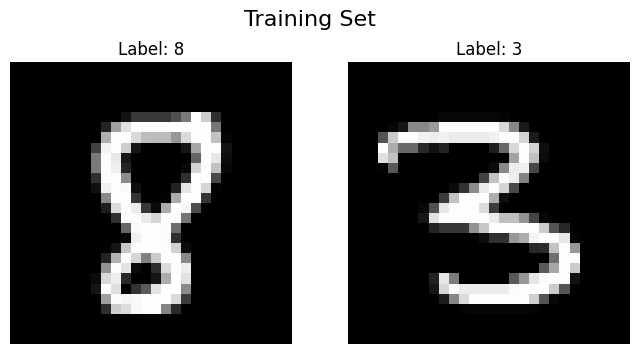

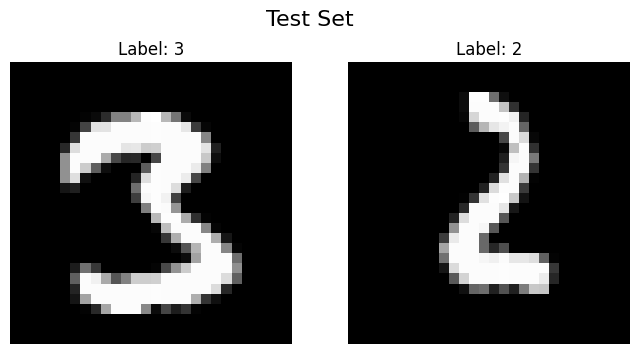

In [5]:
## MNIST visualization
def show_images(images, labels, title):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(2):
        idx = np.random.randint(len(images))
        image = images[idx][0].numpy()
        label = labels[idx].item()
        axes[i].imshow(image[0], cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

# Display 2 randomly chosen images from the training set
show_images(train_data, train_data.targets, "Training Set")
# Display 2 randomly chosen images from the test set
show_images(test_data, test_data.targets, "Test Set")

plt.show()

In [6]:
## Hyperparameters
input_size = 28*28  #Size of image
num_classes = 10   #the image number are in range 0-10
num_epochs =10 #one cycle through the full train data
batch_size = 100 #sample size consider before updating the model’s weights
learning_rate = 0.001  #step size to update parameter
num_hidden = 512
dropout_prob = 0.2
batch_size_mnist  = 100

In [7]:
## Create dataloaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True,num_workers=2)
# Test dataset
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False,num_workers=2)

# Print dataset sizes
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Training set size: 60000
Test set size: 10000


In [8]:
## Define the MLP model and Dropout layers MUST be used
class MLP(nn.Module):
  def __init__(self,input_size, num_hidden, num_classes):
    super(MLP,self).__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(input_size, num_hidden)
    self.droput_1 = nn.Dropout(dropout_prob)
    self.fc2 = nn.Linear(num_hidden,num_hidden)
    self.droput_2 = nn.Dropout(dropout_prob)
    self.fc3 = nn.Linear(num_hidden,num_classes)
    #self.droput_3 = nn.Dropout(dropout_prob)
    #self.fc4 = nn.Linear(num_hidden,num_classes)

  def forward(self,x):
    x = x.view(-1,input_size)
    x = F.relu(self.fc1(x))
    x = self.droput_1(x)
    x = F.relu(self.fc2(x))
    x = self.droput_2(x)
    #x = self.droput_3(x)
    x = self.fc3(x)
    return x



In [9]:
## Set up loss function and optimizer
model =  MLP(input_size, num_hidden, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
## you are free to use other optimizers
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [10]:
## Training of MNIST model
total_step = len(train_loader)
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        model_outputs = model(images.to(device))
        compute_loss = criterion(model_outputs, labels.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        compute_loss.backward()
        optimizer.step()

        # Printing training losses
        if (i+1) % 200 == 0:
            print('Iteration: {0}, training loss = {1:.4f}'.format(i+1, compute_loss.item()))

    # Run testing after each epoch
    with torch.no_grad():
        total = 0
        accurate = 0

        for images, labels in test_loader:
            test_outputs = model(images.to(device))
            _, predicted = torch.max(test_outputs.data, 1)
            total += labels.size(0)
            accurate += (predicted == labels.to(device)).sum().item()

        accuracy_score = 100 * accurate / total
        print('==> Epoch: {0}, test accuracy = {1:.4f}'.format(epoch, accuracy_score))

Iteration: 200, training loss = 0.2490
Iteration: 400, training loss = 0.2539
Iteration: 600, training loss = 0.1401
==> Epoch: 0, test accuracy = 93.9000
Iteration: 200, training loss = 0.2005
Iteration: 400, training loss = 0.0729
Iteration: 600, training loss = 0.1067
==> Epoch: 1, test accuracy = 95.2100
Iteration: 200, training loss = 0.0349
Iteration: 400, training loss = 0.1264
Iteration: 600, training loss = 0.0958
==> Epoch: 2, test accuracy = 95.8300
Iteration: 200, training loss = 0.1059
Iteration: 400, training loss = 0.0882
Iteration: 600, training loss = 0.0801
==> Epoch: 3, test accuracy = 96.0900
Iteration: 200, training loss = 0.1414
Iteration: 400, training loss = 0.0541
Iteration: 600, training loss = 0.2555
==> Epoch: 4, test accuracy = 96.4200
Iteration: 200, training loss = 0.1298
Iteration: 400, training loss = 0.0890
Iteration: 600, training loss = 0.0798
==> Epoch: 5, test accuracy = 96.2900
Iteration: 200, training loss = 0.1280
Iteration: 400, training loss =

In [11]:
# Print MNIST model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
fc1.weight 	 torch.Size([512, 784])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([512, 512])
fc2.bias 	 torch.Size([512])
fc3.weight 	 torch.Size([10, 512])
fc3.bias 	 torch.Size([10])


In [12]:
## Save model for later use
torch.save(model.state_dict(), './mlp_mnist.pt')

In [13]:
!ls -al *.pt

-rw-r--r-- 1 root root 2681564 Feb 28 03:21 mlp_mnist.pt


In [14]:
## Now we load the letters from EMNIST
## use split="letters"


# Download EMNIST-letters dataset
transform_emnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

emnist_letter_dataset = EMNIST(root='./data', split='letters', download=True, train=True, transform=transform)
emnist_train_dataset = EMNIST(root='./data', split='letters', train=True, download=True, transform=transform_emnist)
emnist_test_dataset = EMNIST(root='./data', split='letters', train=False, download=True, transform=transform_emnist)

# Create DataLoader for EMNIST-letters
emnist_train_loader = DataLoader(dataset=emnist_train_dataset, batch_size=64, shuffle=True)
emnist_test_loader = DataLoader(dataset=emnist_test_dataset, batch_size=64, shuffle=False)

100%|██████████| 561753746/561753746 [00:10<00:00, 54719936.31it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


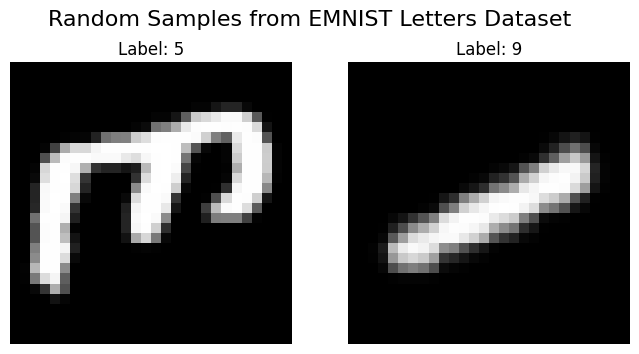

In [15]:
# visualize EMNIST dataset
def show_images(dataset, title, num_images=2):
    fig, axes = plt.subplots(1, num_images, figsize=(8, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        image, label = dataset[idx]
        image = image.numpy()
        axes[i].imshow(image[0], cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()


# Show images with labels using the defined function
show_images(emnist_letter_dataset, "Random Samples from EMNIST Letters Dataset")## we define a new model and load from saved weights

In [16]:
## model_emnist = MLP( ..... )
model_emnist =  MLP(input_size, num_hidden, num_classes).to(device)
model_emnist.load_state_dict(torch.load('./mlp_mnist.pt'))

<All keys matched successfully>

In [17]:
# Modify the output layer for the new number of classes in EMNIST
model_emnist.fc3 = nn.Linear(512, len(emnist_letter_dataset.classes)).to(device)
print(model_emnist)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (droput_1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (droput_2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=27, bias=True)
)


In [18]:
## do an inference on the pre-trained model
## Build the new data loader
loader_emnist = DataLoader(dataset=emnist_letter_dataset, batch_size=64, shuffle=True)
with torch.no_grad():
        total = 0
        accurate = 0

        for images, labels in loader_emnist:
            test_outputs = model_emnist(images.to(device))
            _, predicted = torch.max(test_outputs.data, 1)
            total += labels.size(0)
            accurate += (predicted == labels.to(device)).sum().item()

        accuracy_score = 100 * accurate / total
        print('==> Epoch: {0}, test accuracy = {1:.4f}'.format(epoch, accuracy_score))

==> Epoch: 9, test accuracy = 3.3093


In [19]:
## now we retrain the model with the new data
## The final accuracy must be > 90%!
# Reset optimizer for the new model parameters
optimizer = torch.optim.Adam(model_emnist.parameters(), lr=0.0001)

## training of EMNIST model
total_step = len(emnist_train_loader)
for epoch in range(30):
    for i, (images, labels) in enumerate(emnist_train_loader):
        # Forward pass
        model_outputs = model_emnist(images.to(device))
        compute_loss = criterion(model_outputs, labels.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        compute_loss.backward()
        optimizer.step()

        # Printing training losses
        if (i+1) % 400 == 0:
            print('Iteration: {0}, training loss = {1:.4f}'.format(i+1, compute_loss.item()))

    # Run testing after each epoch
    with torch.no_grad():
        total = 0
        accurate = 0

        for images, labels in emnist_test_loader:
            test_outputs = model_emnist(images.to(device))
            _, predicted = torch.max(test_outputs.data, 1)
            total += labels.size(0)
            accurate += (predicted == labels.to(device)).sum().item()

        accuracy_score = 100 * accurate / total
        print('==> Epoch: {0}, test accuracy = {1:.4f}'.format(epoch, accuracy_score))

Iteration: 400, training loss = 1.8506
Iteration: 800, training loss = 1.2077
Iteration: 1200, training loss = 1.2216
Iteration: 1600, training loss = 0.9950
==> Epoch: 0, test accuracy = 73.9904
Iteration: 400, training loss = 0.8087
Iteration: 800, training loss = 0.7432
Iteration: 1200, training loss = 0.9731
Iteration: 1600, training loss = 0.6538
==> Epoch: 1, test accuracy = 79.9231
Iteration: 400, training loss = 0.8219
Iteration: 800, training loss = 0.3946
Iteration: 1200, training loss = 0.7202
Iteration: 1600, training loss = 0.4073
==> Epoch: 2, test accuracy = 82.6635
Iteration: 400, training loss = 0.5415
Iteration: 800, training loss = 0.5653
Iteration: 1200, training loss = 0.3562
Iteration: 1600, training loss = 0.7399
==> Epoch: 3, test accuracy = 84.3798
Iteration: 400, training loss = 0.4518
Iteration: 800, training loss = 0.4716
Iteration: 1200, training loss = 0.6212
Iteration: 1600, training loss = 0.3866
==> Epoch: 4, test accuracy = 85.6971
Iteration: 400, trai

In [20]:
from torchvision.models import resnet18
# Set input size for ResNet
input_size = 224

# Define data transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
])

# Load and preprocess EMNIST dataset
emnist_dataset = EMNIST(root="./", split="letters", train=True, transform=transform, download=True)
emnist_train_size = int(0.8 * len(emnist_dataset))
emnist_test_size = len(emnist_dataset) - emnist_train_size
emnist_train_dataset, emnist_test_dataset = random_split(emnist_dataset, [emnist_train_size, emnist_test_size])

emnist_train_loader = DataLoader(emnist_train_dataset, batch_size=64, shuffle=True)
emnist_test_loader = DataLoader(emnist_test_dataset, batch_size=64, shuffle=False)

# Load and preprocess KMNIST dataset
kmnist_dataset = KMNIST(root="./", train=True, transform=transform, download=True)
kmnist_train_size = int(0.8 * len(kmnist_dataset))
kmnist_test_size = len(kmnist_dataset) - kmnist_train_size
kmnist_train_dataset, kmnist_test_dataset = random_split(kmnist_dataset, [kmnist_train_size, kmnist_test_size])

kmnist_train_loader = DataLoader(kmnist_train_dataset, batch_size=64, shuffle=True)
kmnist_test_loader = DataLoader(kmnist_test_dataset, batch_size=64, shuffle=False)

# Load pre-trained ResNet model
pretrained_resnet = resnet18(pretrained=True)
pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, len(emnist_dataset.classes))

# Move the model to the GPU
pretrained_resnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_resnet.parameters(), lr=0.001)

100%|██████████| 561753746/561753746 [00:07<00:00, 72193367.52it/s] 


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


100%|██████████| 18165135/18165135 [00:16<00:00, 1128098.71it/s]


Extracting ./KMNIST/raw/train-images-idx3-ubyte.gz to ./KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 203171.38it/s]


Extracting ./KMNIST/raw/train-labels-idx1-ubyte.gz to ./KMNIST/raw



100%|██████████| 3041136/3041136 [00:03<00:00, 902157.63it/s]


Extracting ./KMNIST/raw/t10k-images-idx3-ubyte.gz to ./KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 5810291.26it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


Extracting ./KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./KMNIST/raw



100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


In [21]:
# Function to train the model
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    model.to(device)  # Move the model to the specified device
    for epoch in range(num_epochs):
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.5f}")

# Function to evaluate the model on a given data loader
def evaluate(model, data_loader, device='cuda'):
    model.eval()
    model.to(device)  # Move the model to the specified device
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [22]:
# Train and evaluate using resnet18
train(pretrained_resnet, emnist_train_loader, criterion, optimizer, num_epochs=5)


Epoch 1/5, Loss: 0.10189
Epoch 2/5, Loss: 0.22301
Epoch 3/5, Loss: 0.08850
Epoch 4/5, Loss: 0.18245
Epoch 5/5, Loss: 0.13298


In [23]:
# Evaluate on EMNIST-text test set
emnist_test_accuracy = evaluate(pretrained_resnet, emnist_test_loader, device='cuda')
print(f"Accuracy on EMNIST test set: {emnist_test_accuracy * 100:.2f}%")

Accuracy on EMNIST test set: 95.29%


In [24]:
# Fine-tune on KMNIST
pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, len(kmnist_dataset.classes))
optimizer = torch.optim.Adam(pretrained_resnet.parameters(), lr=0.001)

In [25]:
#Train the resnet on KMNIST data
#train(pretrained_resnet, kmnist_train_loader, criterion, optimizer)
train(pretrained_resnet, kmnist_train_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.04264
Epoch 2/5, Loss: 0.03602
Epoch 3/5, Loss: 0.02762
Epoch 4/5, Loss: 0.00150
Epoch 5/5, Loss: 0.00314


In [26]:
# Evaluate on KMNIST test set
kmnist_test_accuracy = evaluate(pretrained_resnet, kmnist_test_loader)
print(f"Accuracy on KMNIST test set: {kmnist_test_accuracy * 100:.2f}%")

Accuracy on KMNIST test set: 98.67%
